# Training and Validation Script

## Import Library

In [19]:
import os
import re
import zipfile
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import gdown
import zipfile

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Import Dataset (Need to be automated and consistent)

In [20]:
url = "https://drive.google.com/file/d/1tYM-45FgvabZgCORbWcsmAHDQ4s10Eoi/view?usp=drive_link"
output = "dataset.zip"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1tYM-45FgvabZgCORbWcsmAHDQ4s10Eoi
To: /content/dataset.zip
100%|██████████| 9.15M/9.15M [00:00<00:00, 120MB/s]


'dataset.zip'

In [21]:
# download zip file dataset from https://drive.google.com/drive/folders/1nwR-wo-_9mQtqkVJd3Grhlw6YGPX4EKP?usp=share_link
filenames = os.listdir()

for file in filenames:
  dataset = re.search(r'^dataset.*\.zip$', file)

  if dataset:
    zip_path = f'./{file}'
    zip_ref = zipfile.ZipFile(zip_path, 'r')
    zip_ref.extractall(path='./')
    zip_ref.close()

## ETL (Extract Transform Load)

In [22]:
# Create dataset builder

# Extract (Specifying path)
base_dir = './dataset/'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Extract (Generating dataset from directory)
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
VAL_SPLIT = 0.2

def build_dataset(train_val, dir, subset=None):
  if train_val:
    return tf.keras.preprocessing.image_dataset_from_directory(
        dir,
        validation_split=VAL_SPLIT,
        subset=subset,
        label_mode="binary",
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        seed=123)
  else:
    return tf.keras.preprocessing.image_dataset_from_directory(
        dir,
        # labels='inferred',
        label_mode='binary',
        # class_names=['caries', 'no-caries'],
        batch_size=BATCH_SIZE,)


# Execute dataset building
train_ds = build_dataset(True, train_dir, "training")
val_ds = build_dataset(True, train_dir, "validation")
test_ds = build_dataset(False, test_dir)

class_names = tuple(train_ds.class_names)
print(class_names)

Found 500 files belonging to 2 classes.
Using 400 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.
Found 32 files belonging to 2 classes.
('caries', 'no-caries')


In [23]:
# Check batches' shape
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 1)


### Preprocessing Images using keras preprocessing layers

In [25]:
# Transform (Preprocessing data)

# optimize data I/O
AUTOTUNE = tf.data.AUTOTUNE

IMG_SIZE = 224

image = next(iter(train_ds))

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomTranslation(0, 0.2),
  layers.RandomTranslation(0.2, 0),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomBrightness(0.2)
])

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)


train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
# Load (Apply preprocessing and load data)

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [ ]:
# # experimental ImageDatagenerator for training (not used at the moment)
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         # rotation_range=40,
#         # width_shift_range=0.2,
#         # height_shift_range=0.2,
#         # shear_range=0.2,
#         # zoom_range=0.2,
#         # horizontal_flip=True,
#         # fill_mode='nearest'
# )
# test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(
#         train_dir,
#         target_size=(150, 150),
#         batch_size=20,
#         class_mode='binary')

# test_generator = test_datagen.flow_from_directory(
#         test_dir,
#         target_size=(150, 150),
#         batch_size=20,
#         class_mode='binary')

### Building Model using Transfer Learning

In [27]:
# transfer learning not final (maybe can use less layer?)
model_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = model_selection
IMAGE_SIZE = (pixels, pixels)

MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
pre_trained_model = hub.KerasLayer(MODULE_HANDLE, input_shape=IMAGE_SIZE + (3,))
pre_trained_model.trainable = False

print(f"Selected model: {MODULE_HANDLE}")

Selected model: https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4


In [ ]:
# Inception V3 model
# pre_trained_model = InceptionV3(input_shape = (255, 255, 3), 
#                                 include_top = False, 
#                                 weights = 'imagenet')

In [ ]:
# # Check feature vector dimension

# image_batch, label_batch = next(iter(train_ds))
# feature_batch = pre_trained_model(image_batch)
# print(feature_batch.shape)

In [75]:
# # not final
# model = tf.keras.Sequential([
#   feature_extractor,
#   tf.keras.layers.Dense(1, activation='sigmoid') # sigmoid/softmax
# ])

# model.summary()

model = tf.keras.Sequential([
    layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    pre_trained_model,
    # Our custom layers
    layers.Dropout(0.2),
    # layers.Dense(128, activation="relu"),
    layers.Dense(1, activation='sigmoid', name="outputs")
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_5 (Dropout)         (None, 1280)              0         
                                                                 
 outputs (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
# # Model building for Inception V3
# x = layers.Flatten()(pre_trained_model.output)
# x = layers.Dense(1024, activation="relu")(x)
# x = layers.Dropout(0.2)(x)
# x = layers.Dense(1, activation='sigmoid')(x)

# model = tf.keras.Model(pre_trained_model.input, x)

In [58]:
model.compile(
  optimizer = optimizers.Adam(), 
  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), 
  metrics = ['accuracy']
)

## Model Training

In [59]:
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = 100,
  verbose = 2)

Epoch 1/50
13/13 - 10s - loss: 0.7703 - accuracy: 0.5100 - val_loss: 0.5783 - val_accuracy: 0.5500 - 10s/epoch - 736ms/step
Epoch 2/50
13/13 - 7s - loss: 0.6874 - accuracy: 0.5625 - val_loss: 0.4411 - val_accuracy: 0.6800 - 7s/epoch - 511ms/step
Epoch 3/50
13/13 - 6s - loss: 0.7312 - accuracy: 0.5250 - val_loss: 0.3363 - val_accuracy: 0.9300 - 6s/epoch - 449ms/step
Epoch 4/50
13/13 - 7s - loss: 0.6553 - accuracy: 0.5800 - val_loss: 0.2731 - val_accuracy: 0.9500 - 7s/epoch - 516ms/step
Epoch 5/50
13/13 - 6s - loss: 0.6439 - accuracy: 0.5525 - val_loss: 0.2636 - val_accuracy: 0.9300 - 6s/epoch - 446ms/step
Epoch 6/50
13/13 - 6s - loss: 0.6470 - accuracy: 0.5875 - val_loss: 0.2354 - val_accuracy: 0.9500 - 6s/epoch - 439ms/step
Epoch 7/50
13/13 - 6s - loss: 0.6265 - accuracy: 0.5825 - val_loss: 0.2221 - val_accuracy: 0.9400 - 6s/epoch - 436ms/step
Epoch 8/50
13/13 - 7s - loss: 0.6401 - accuracy: 0.6075 - val_loss: 0.1944 - val_accuracy: 0.9500 - 7s/epoch - 520ms/step
Epoch 9/50
13/13 - 6s 

## Model Evaluation

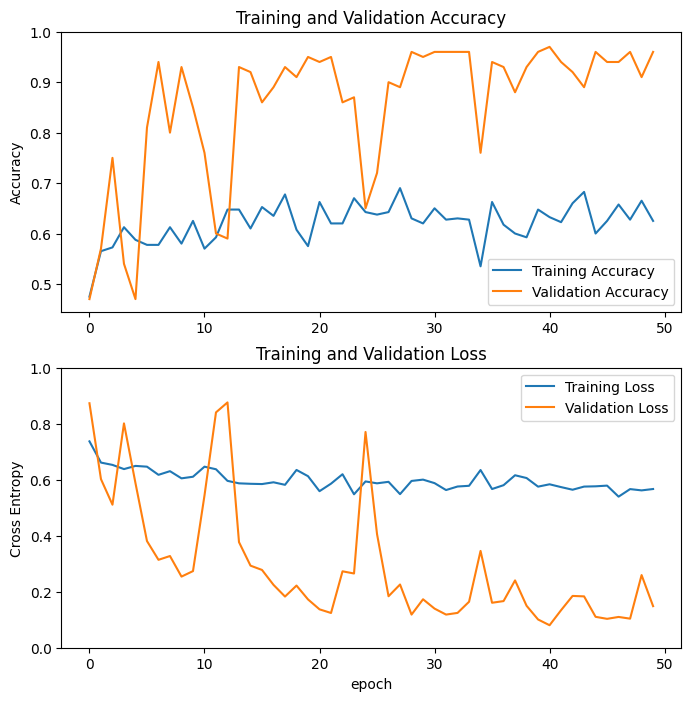

In [46]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning Model (Please RUN after training with freezed layers)

In [65]:
# Unfreeze layers to retrain model
pre_trained_model.trainable = True
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_20 (Dense)            (None, 128)               163968    
                                                                 
 outputs (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,422,081
Trainable params: 2,387,969
Non-trainable params: 34,112
_________________________________________________________________


In [80]:
model.compile(
  optimizer = optimizers.Adam(), 
  loss = 'binary_crossentropy', 
  metrics = ['accuracy']
)

In [85]:
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = 100,
  verbose = 2)

Epoch 1/100
13/13 - 11s - loss: 0.5151 - accuracy: 0.7075 - val_loss: 0.2104 - val_accuracy: 0.9300 - 11s/epoch - 847ms/step
Epoch 2/100
13/13 - 11s - loss: 0.4600 - accuracy: 0.7525 - val_loss: 0.3655 - val_accuracy: 0.8400 - 11s/epoch - 859ms/step
Epoch 3/100
13/13 - 7s - loss: 0.4782 - accuracy: 0.7250 - val_loss: 0.2632 - val_accuracy: 0.8900 - 7s/epoch - 506ms/step
Epoch 4/100
13/13 - 7s - loss: 0.5146 - accuracy: 0.7025 - val_loss: 0.6229 - val_accuracy: 0.7100 - 7s/epoch - 536ms/step
Epoch 5/100
13/13 - 6s - loss: 0.4937 - accuracy: 0.7300 - val_loss: 0.1990 - val_accuracy: 0.9200 - 6s/epoch - 467ms/step
Epoch 6/100
13/13 - 7s - loss: 0.4774 - accuracy: 0.7350 - val_loss: 0.2266 - val_accuracy: 0.9200 - 7s/epoch - 534ms/step
Epoch 7/100
13/13 - 7s - loss: 0.4877 - accuracy: 0.7225 - val_loss: 0.3089 - val_accuracy: 0.8800 - 7s/epoch - 534ms/step
Epoch 8/100
13/13 - 6s - loss: 0.5378 - accuracy: 0.6975 - val_loss: 0.1891 - val_accuracy: 0.9700 - 6s/epoch - 467ms/step
Epoch 9/100


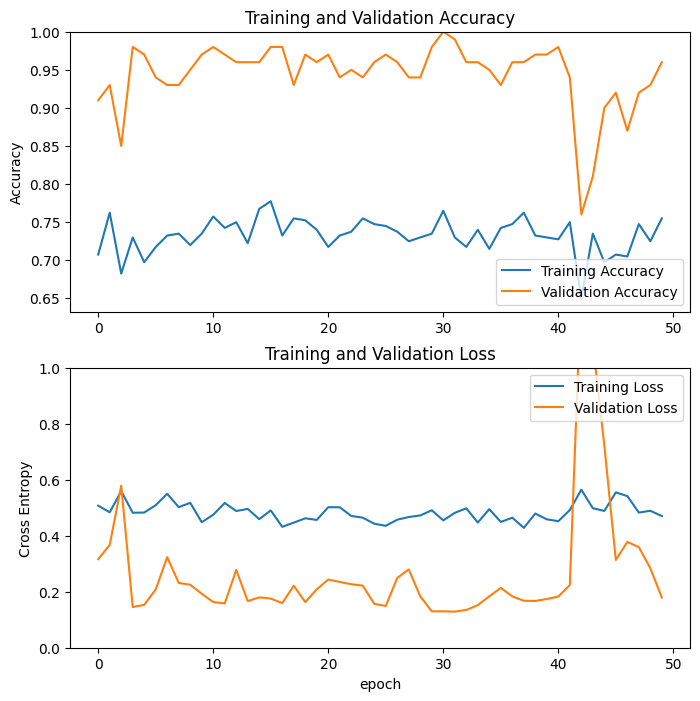

In [82]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [84]:
# change filename to file you want to predict
filename = 'caries.jpg'
img = load_img(filename, target_size=(224, 224))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes)

1/1 [==============================] - 0s 25ms/step
[[8.676442e-05]]


## TODO
* Build Flask app
* User image input???????
* Create better evaluation and prediction
* Create save model function to .h5 format
* How to deploy the model?